In [52]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance
import librosa
import librosa.display
import matplotlib.pyplot as plt
import shap
import sys
sys.path.append("../")
import utils
import joblib
import os
import importlib
importlib.reload(utils)
from utils import * 

In [44]:
# HYERPARAMETERS
FILEPATH = '/Users/andreaalberti/Desktop/Public_Projects/advanced-biomedical-project/dataset/murmurs_4000/abnormal_s3_2023_18.wav'

SEED = 42
INTERVAL = 1

BALANCING_TYPE = "none"
RESULT_NAME = f"results_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
CM_NAME = f"cm_ensemble_v4_best_features_{BALANCING_TYPE}.csv"
mod = "../../models/MLP_rollercoaster_none.joblib"

# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + "raw/"
# FEATURES = FEATURES_BASE + 'balanced/posteriori/'
FOLDERS_LIST = ['murmurs_4000/', 'artifacts_4000/', 'normals_4000/', 'extrahls_4000/', 'extrastoles_4000/']
FILEINDEX = 0 # file index of each folder wrt which the spectrogram and waveform explanations are computed
FILEINDEXES = [2, 3, 94, 14, 23] #the most significant file index for each class
FILEINDEXES = [97, 82, 281, 4, 35] #the most significant file index for each class
important_mfccs = [[3, 6, 11, 16], [4, 3, 8, 10], [3, 4, 17, 16], [8, 6, 3, 4], [24, 15, 3, 6]]
important_mfccs = [[3, 6, 11], [4, 3, 8], [3, 4, 17], [8, 6, 3], [24, 15, 3]]


# Models
MODELS_PATH = "../../models/"
MODELS_RESULTS = MODELS_PATH + "results/"
BEST_MODEL = MODELS_PATH + f"MLP_rollercoaster_{BALANCING_TYPE}.joblib"
# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"


# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
num_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}

COMPLETE_DATA_PRIOR_CORR_NAME = (
    f"full_data_filtered_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in num_feats.items())
    + ".npy"
)
# load the data
full_data = np.load(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
n_cols = full_data["train"]["X"].shape[1]

model = joblib.load(BEST_MODEL)

X_train = full_data["train"]["X"]
y_train = full_data["train"]["y"]
X_test = full_data["test"]["X"]
y_test = full_data["test"]["y"]

features_name = full_data["features"]

In [3]:
# # Define the model (as per your provided model)
# SEED = 42
# voting_clf = VotingClassifier(estimators=[
#     ("RandomForest", RandomForestClassifier(random_state=SEED)),
#     ("MLP_Ultra",MLPClassifier(hidden_layer_sizes=(512,256,128,64,32,),activation="relu",solver="adam",random_state=SEED,),),
#     ("MLP_Rollercoaster",MLPClassifier(hidden_layer_sizes=(512, 128, 256, 128, 256, 64, 32),activation="relu",solver="adam",random_state=SEED,),),],
#     voting="soft",)

# # Assuming X_train and y_train are your training data and labels
# # Train the model
# voting_clf.fit(X_train, y_train)

# # Compute permutation importance
# perm_importance = permutation_importance(voting_clf, X_train, y_train, n_repeats=30, random_state=SEED)

# # Identify the most important MFCCs
# sorted_idx = perm_importance.importances_mean.argsort()
# important_mfccs = sorted_idx[-3:]  # Get indices of the top 5 important MFCCs
# print("Important MFCC indices:", important_mfccs)

# for i in important_mfccs:
#     print(f"Feature {i}: {features_name[i]}")
    
# important_mfccs = [int(features_name[i].split(" ")[1]) for i in important_mfccs]

Important MFCC indices: [3 1 0]
Feature 3: MFCC 6
Feature 1: MFCC 4
Feature 0: MFCC 3


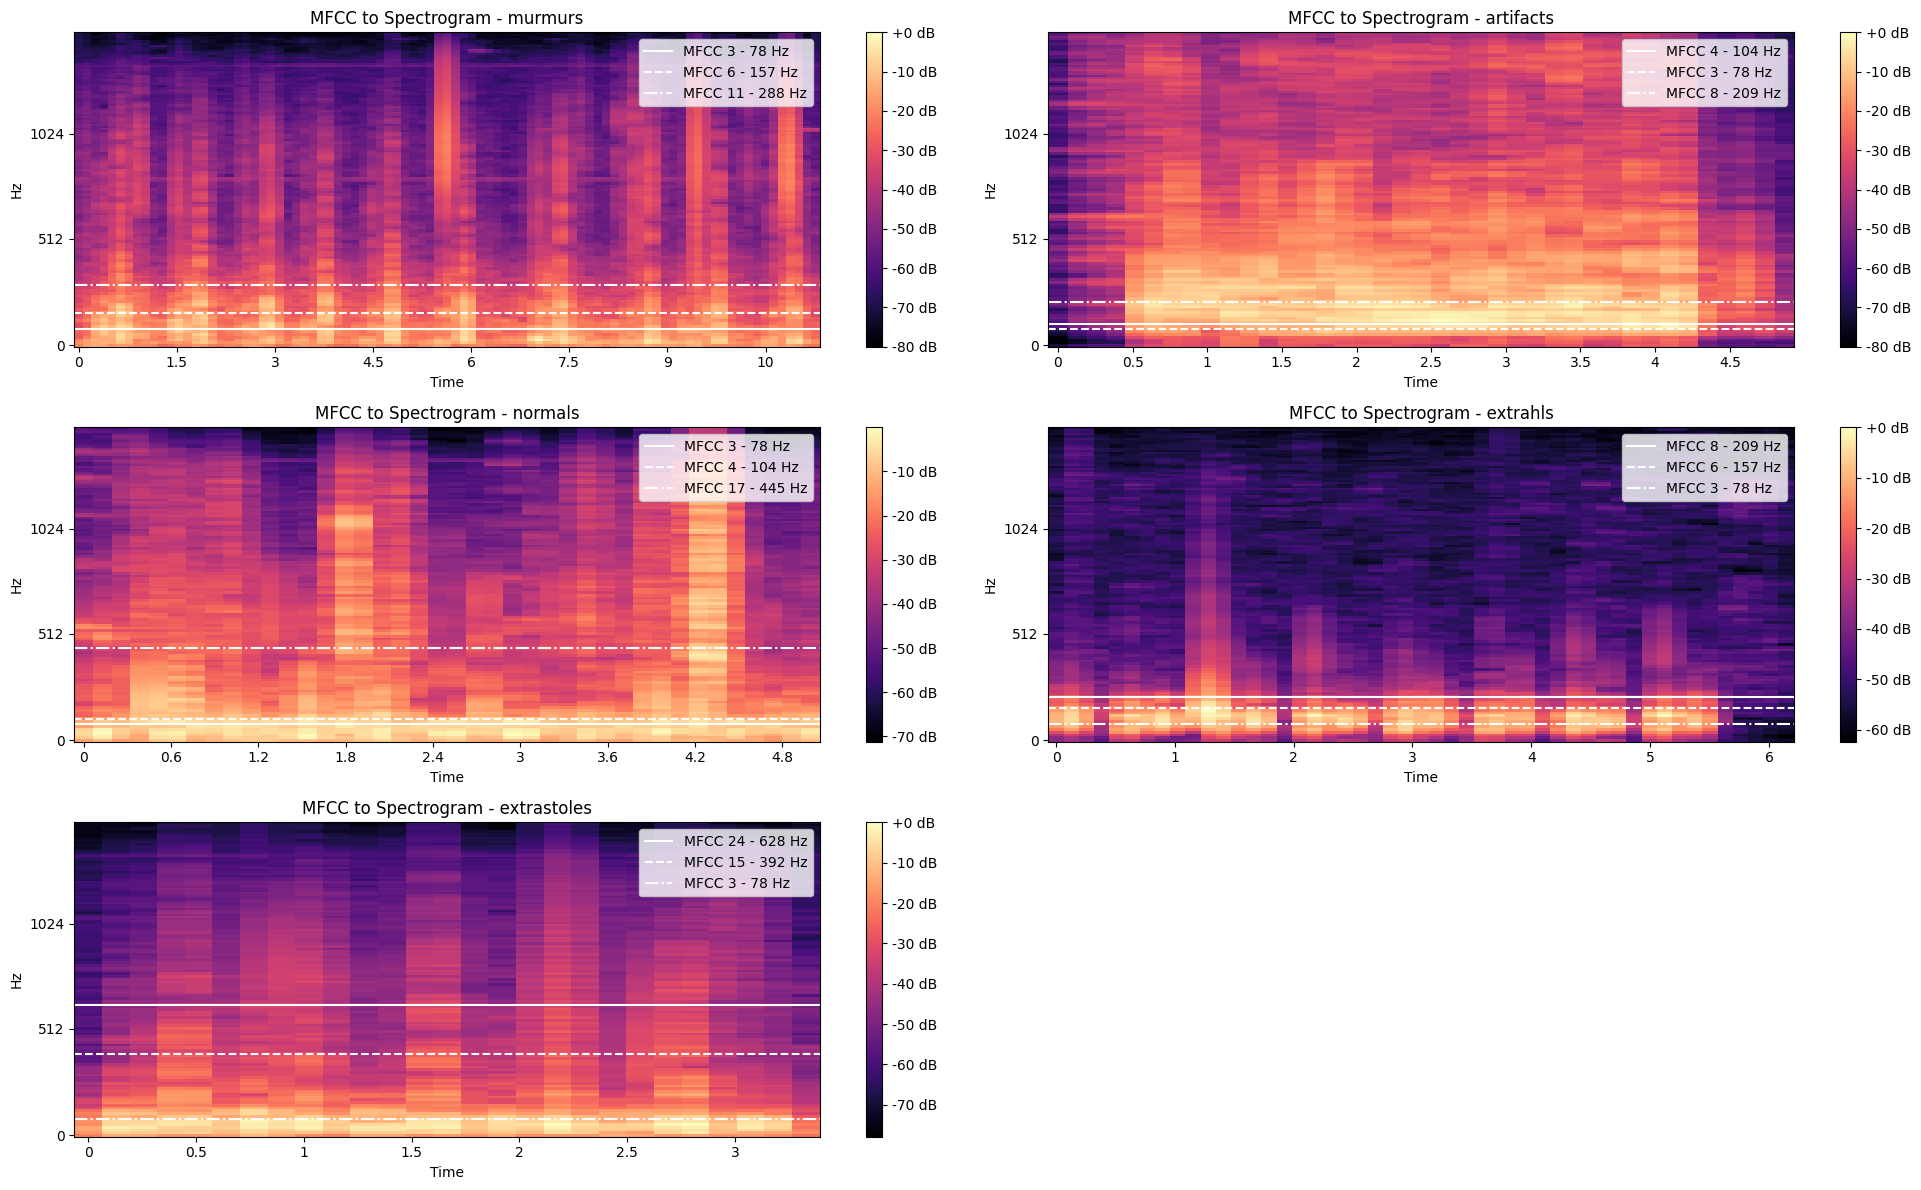

In [53]:
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate over folders and plot on each subplot
for i, FOLDER in enumerate(FOLDERS_LIST):
    file = os.listdir(os.path.join(BASE_DIR, FOLDER))[FILEINDEXES[i]]
    audio, sr = librosa.load(os.path.join(BASE_DIR, FOLDER, file), sr=4000)
    plot_mfcc_to_spectrogram(audio, axs[i], sr, important_mfccs[i], title=FOLDER[:-6])

# Remove any empty subplots (if any)
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [54]:
important_mfccs_ = [3]

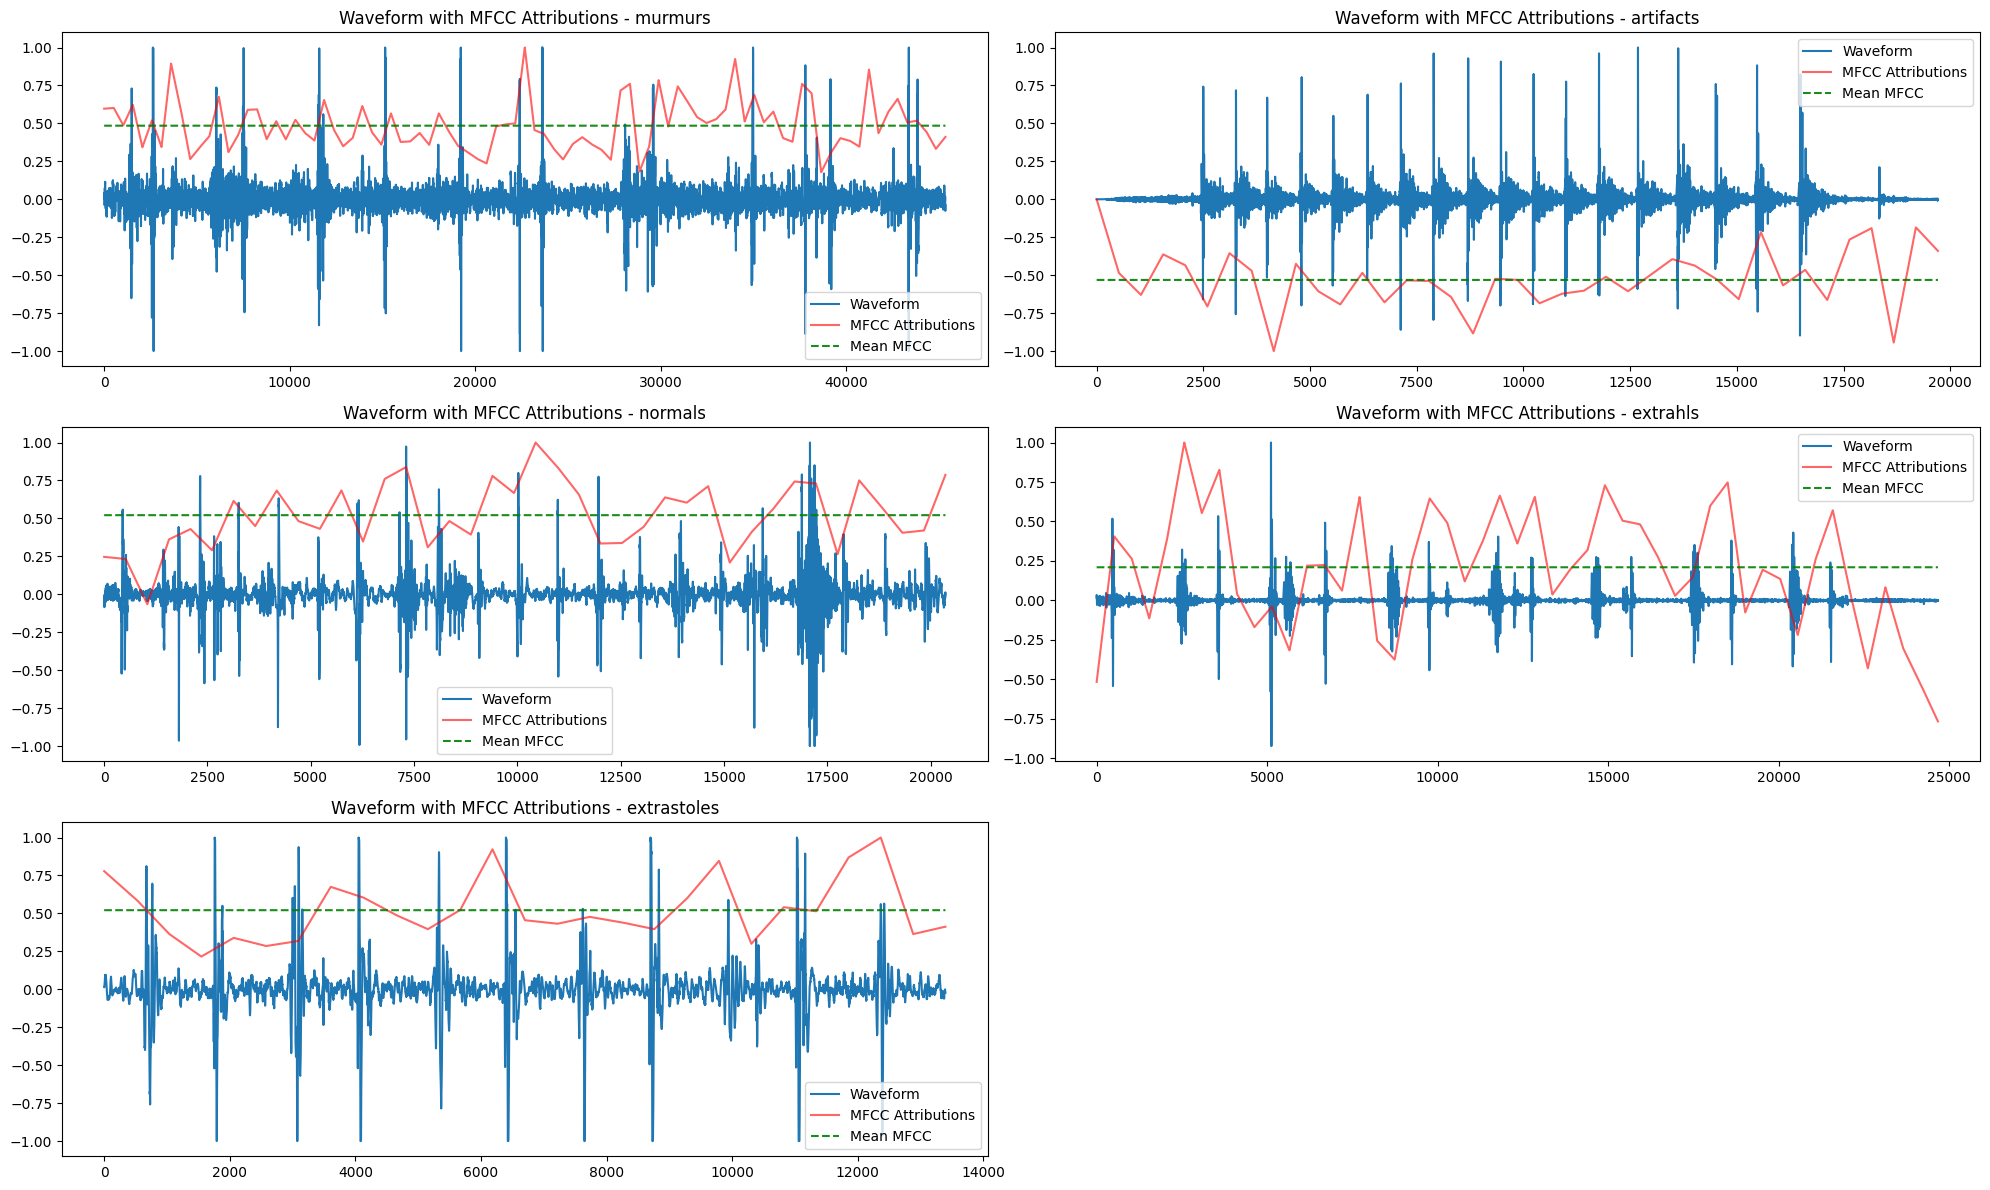

In [55]:
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate over folders and plot on each subplot
for i, FOLDER in enumerate(FOLDERS_LIST):
    file = os.listdir(BASE_DIR + FOLDER)[FILEINDEXES[i]]
    audio, sr = librosa.load(os.path.join(BASE_DIR, FOLDER, file), sr=4000)
    plot_waveform_with_mfcc_attributions(audio, axs[i], sr, important_mfccs_, title=FOLDER[:-6], melkwargs={'hop_length': 512})

# Remove any empty subplots (if any)
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torchaudio
import torch

def plot_waveform_with_mfcc_attributions(audio: np.ndarray, ax: plt.Axes, sr: int = 4000, important_mfccs: list = None, title: str = None, melkwargs: dict = {}) -> None:
    """
    Plot the waveform of an audio signal along with the attributions computed for important MFCCs.

    Parameters:
    audio (ndarray): The audio signal.
    ax (plt.Axes): The matplotlib axis to plot on.
    sr (int): The sample rate of the audio signal (default is 4000).
    important_mfccs (list): A list of indices representing the important MFCCs (default is None).
    title (str): The title of the plot (default is None).

    Returns:
    None
    """
    # Compute MFCCs using librosa and torchaudio for validation
    mfccs_librosa = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=60)
    mfccs_torchaudio = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=60, melkwargs=melkwargs)(torch.tensor(audio).unsqueeze(0)).squeeze(0).numpy()
    
    # Decide which MFCCs to use (librosa or torchaudio)
    mfccs = mfccs_torchaudio
    
    # Normalize audio for plotting
    audio_norm = normalize(audio.reshape(1, -1)).flatten()
    
    # Placeholder for total attributions
    total_attributions = np.zeros_like(audio)
    
    # Plot waveform
    ax.plot(audio_norm, label='Waveform')
    
    # Compute and plot attributions for each important MFCC
    for mfcc in important_mfccs:
        # Reshape and stretch MFCC values to match the length of the audio
        mfcc_values = mfccs[mfcc]
        mfcc_stretched = np.interp(np.arange(len(audio)), np.linspace(0, len(audio), len(mfcc_values)), mfcc_values)
        
        # Normalize attributions
        attributions_norm = normalize(mfcc_stretched.reshape(1, -1)).flatten()
        
        # Add to total attributions
        total_attributions += mfcc_stretched
        
        # Plot attributions
        ax.plot(attributions_norm, label=f'MFCC {mfcc} Attribution', alpha=0.6)
    
    # Normalize total attributions
    total_attributions_norm = normalize(total_attributions.reshape(1, -1)).flatten()
    
    # Plot total attributions
    #ax.plot(total_attributions_norm, label='Total MFCC Attributions', color='r', alpha=0.6)
    
    # Plot mean MFCC as a reference
    mean_mfcc = np.mean(mfccs[important_mfccs], axis=0)
    mean_mfcc_stretched = np.interp(np.arange(len(audio)), np.linspace(0, len(audio), len(mean_mfcc)), mean_mfcc)
    mean_mfcc_norm = normalize(mean_mfcc_stretched.reshape(1, -1)).flatten()
    #ax.plot(mean_mfcc_norm, label='Mean MFCC', color='g', alpha=0.9, linestyle='--')
    
    # Add legend and title if provided
    ax.legend()
    if title:
        ax.set_title(f'Waveform with MFCC Attributions - {title}')

# Example usage:
# fig, ax = plt.subplots()
# plot_waveform_with_mfcc_attributions(audio=np.random.randn(4000), ax=ax, important_mfccs=[1, 2, 3], title='Example Plot')
# plt.show()


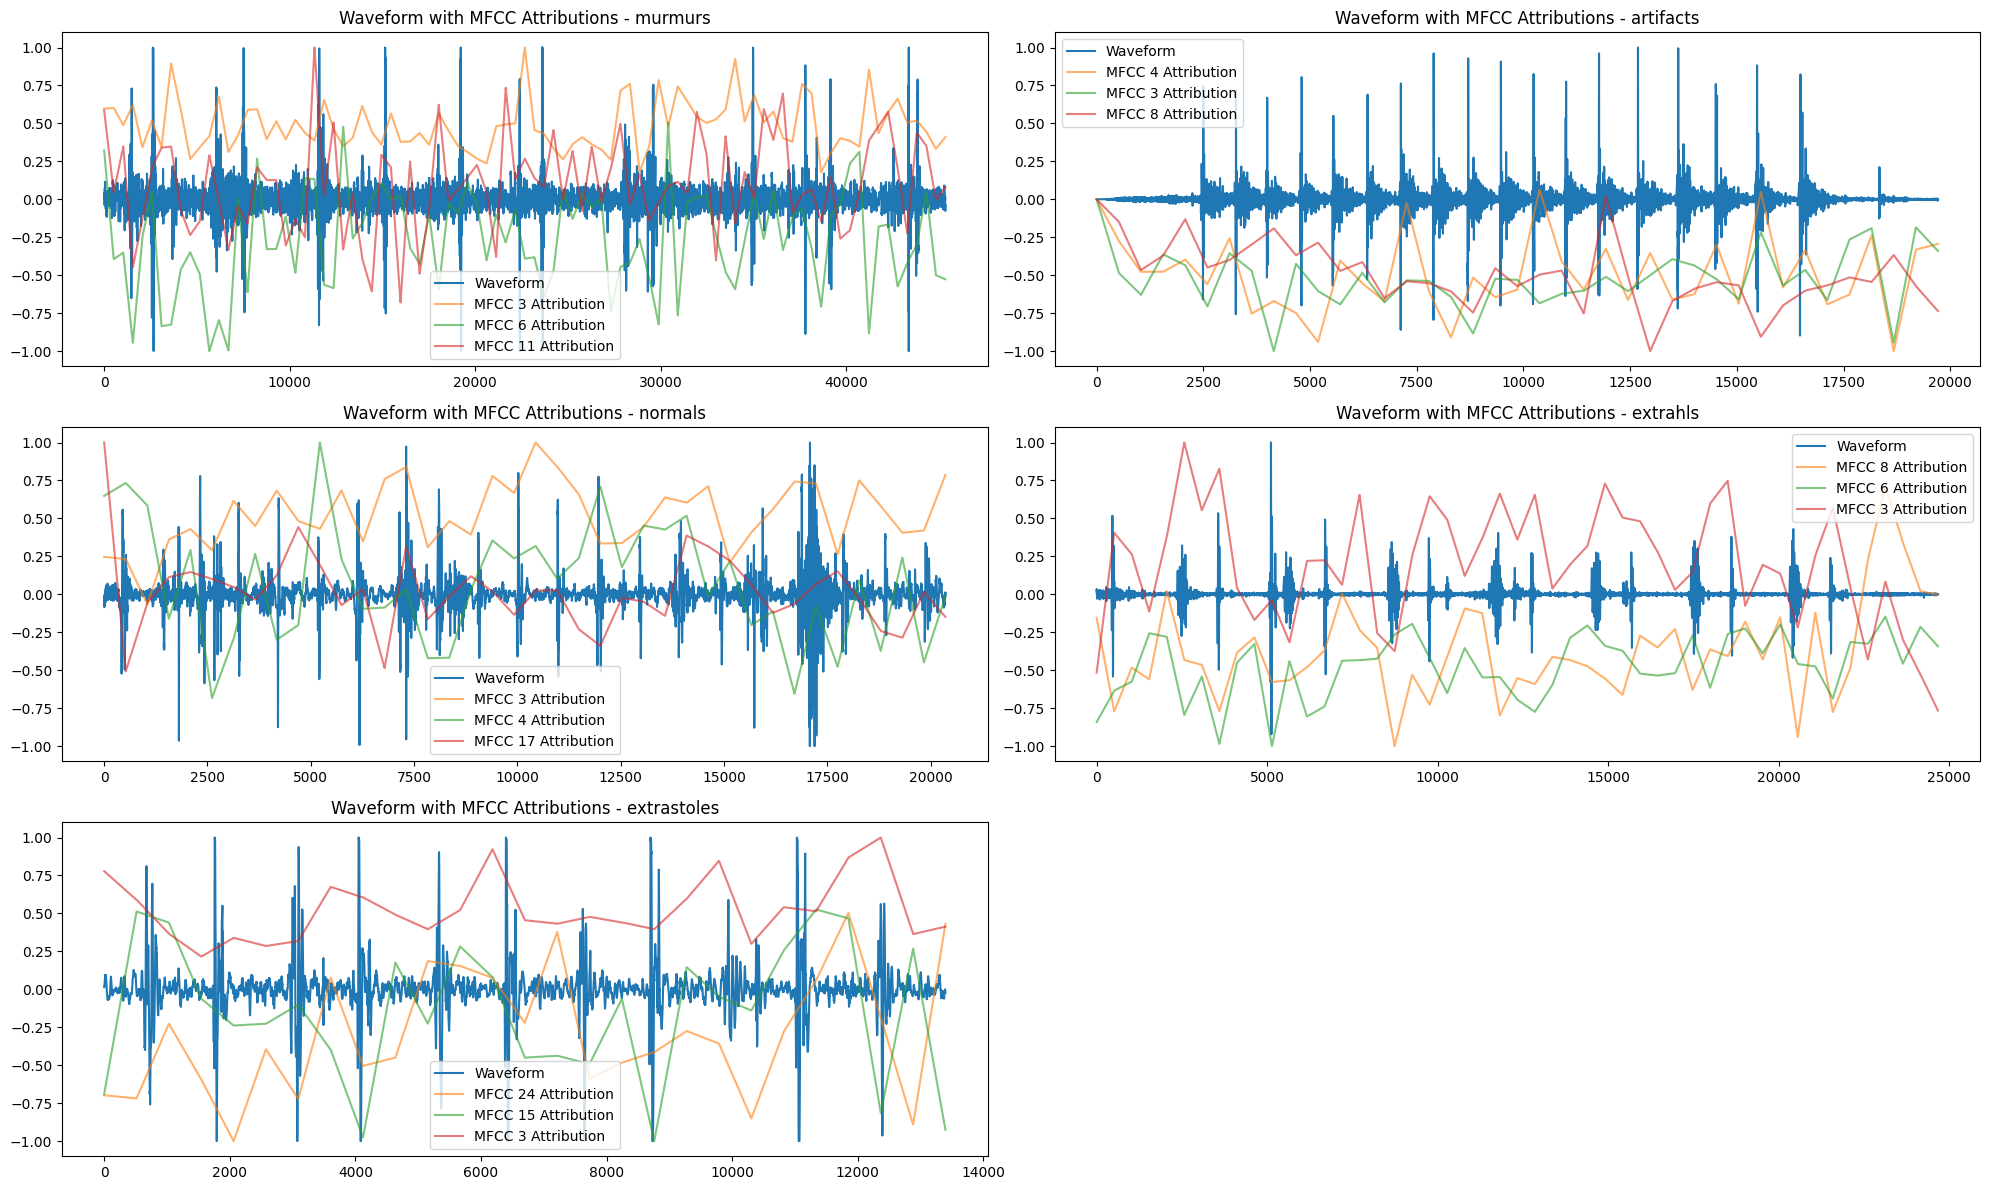

In [64]:
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate over folders and plot on each subplot
for i, FOLDER in enumerate(FOLDERS_LIST):
    file = os.listdir(BASE_DIR + FOLDER)[FILEINDEXES[i]]
    audio, sr = librosa.load(os.path.join(BASE_DIR, FOLDER, file), sr=4000)
    plot_waveform_with_mfcc_attributions(audio, axs[i], sr, important_mfccs[i], title=FOLDER[:-6], melkwargs={'hop_length': 512})

# Remove any empty subplots (if any)
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

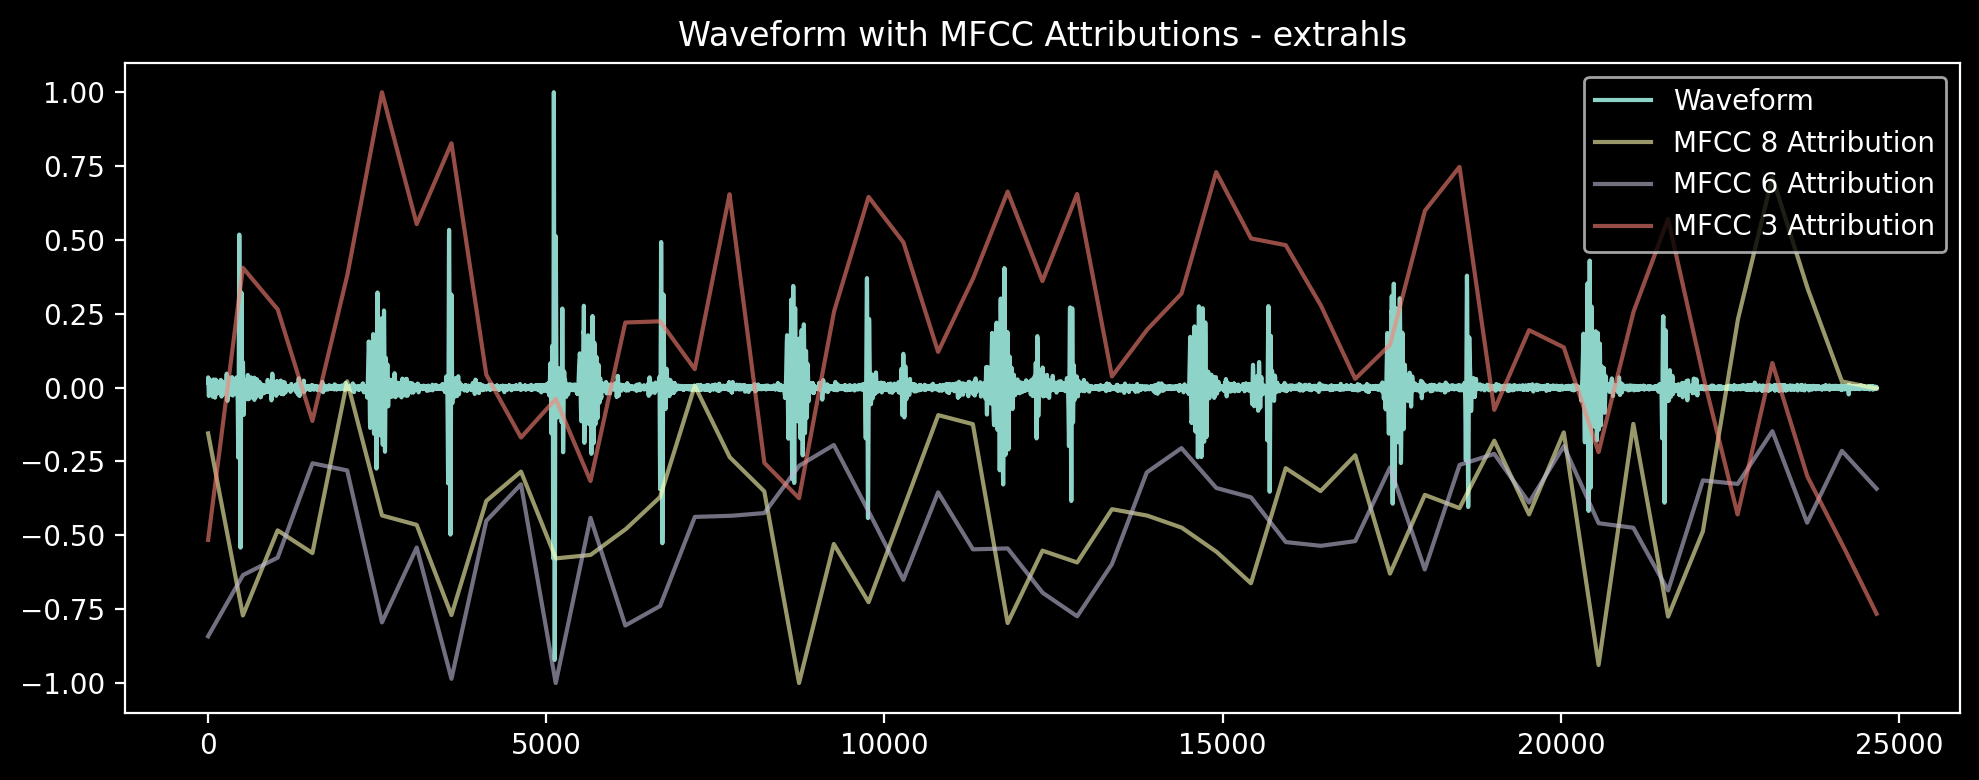

In [88]:
# Create subplots
fig, axs = plt.subplots(1,1, figsize=(10, 4), dpi = 200)


# Iterate over folders and plot on each subplot
for i, FOLDER in enumerate(FOLDERS_LIST):
    file = os.listdir(BASE_DIR + FOLDER)[FILEINDEXES]
    audio, sr = librosa.load(os.path.join(BASE_DIR, FOLDER, file), sr=4000)
    plot_waveform_with_mfcc_attributions(audio, axs, sr, important_mfccs, title=FOLDER[:-6], melkwargs={'hop_length': 512})


plt.tight_layout()
plt.show()

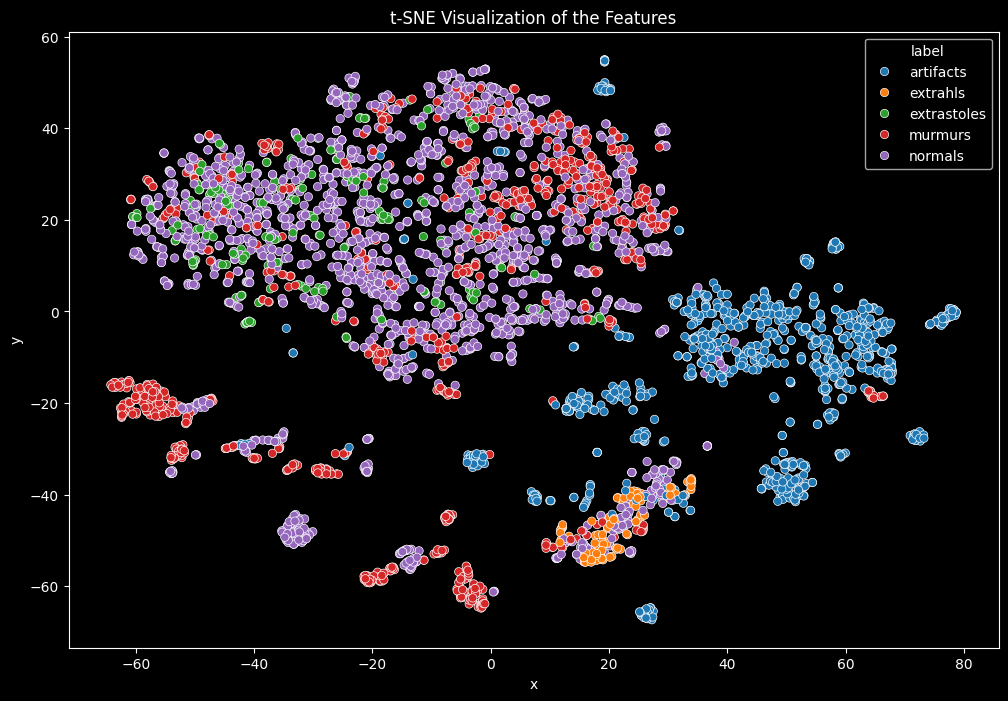

In [89]:
# visualize the features with t-SNE
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Fit t-SNE
tsne = TSNE(n_components=2, random_state=SEED)
X_embedded = tsne.fit_transform(X_train)

# Create a DataFrame for visualization
df = pd.DataFrame(X_embedded, columns=["x", "y"])
df["label"] = y_train
df["label"] = df["label"].map({0: "artifacts", 1: "extrahls", 2: "murmurs", 3: "normals", 4: "extrastoles"})
df["label"] = df["label"].astype("category")

# Plot the t-SNE visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="tab10")
plt.title("t-SNE Visualization of the Features")
plt.show()


Important MFCC indices: [20 16 11 15 10 14 13 21 24 12  9  8  6  7  4  5  2  3  1  0]
Feature 20: MFCC 23
Feature 16: MFCC 19
Feature 11: MFCC 14
Feature 15: MFCC 18
Feature 10: MFCC 13
Feature 14: MFCC 17
Feature 13: MFCC 16
Feature 21: MFCC 24
Feature 24: MFCC 27
Feature 12: MFCC 15
Feature 9: MFCC 12
Feature 8: MFCC 11
Feature 6: MFCC 9
Feature 7: MFCC 10
Feature 4: MFCC 7
Feature 5: MFCC 8
Feature 2: MFCC 5
Feature 3: MFCC 6
Feature 1: MFCC 4
Feature 0: MFCC 3


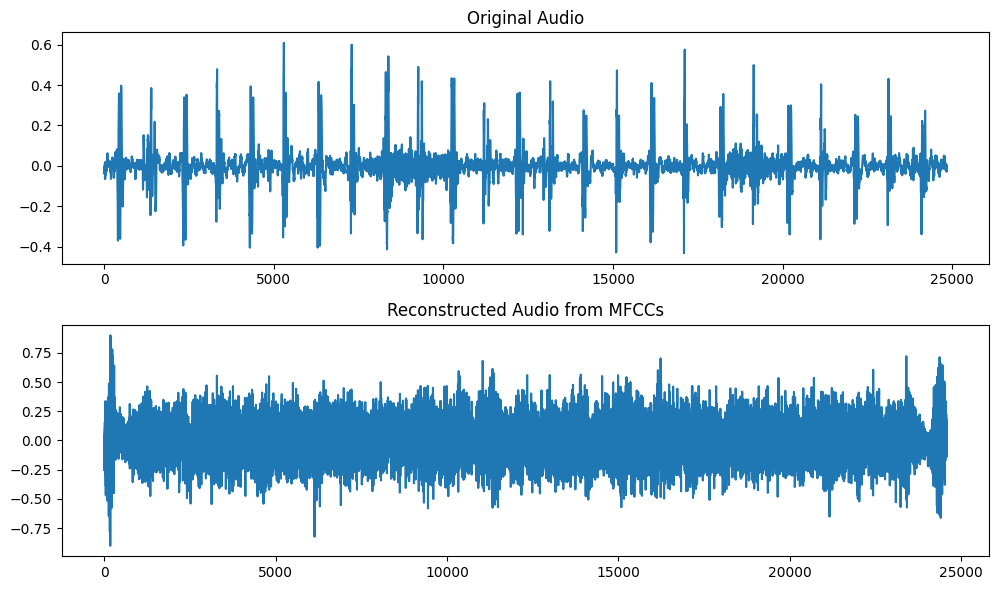

In [140]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load an example audio file
audio_path = '/Users/andreaalberti/Desktop/Public_Projects/advanced-biomedical-project/dataset/normals_4000/normal__103_1305031931979_B.wav'
audio, sr = librosa.load(audio_path, sr=4000)

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=30)

# pick important mfccs
important_mfccs = sorted_idx[-20:]  # Get indices of the top 5 important MFCCs
print("Important MFCC indices:", important_mfccs)
for i in important_mfccs:
    print(f"Feature {i}: {features_name[i]}")
important_mfccs = [int(features_name[i].split(" ")[1]) for i in important_mfccs]
mfccs = mfccs[important_mfccs]

# Invert MFCCs to audio
reconstructed_audio = librosa.feature.inverse.mfcc_to_audio(mfccs, n_mels=128, dct_type=2, norm='ortho')

# Plot original and reconstructed audio signals
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(audio)
plt.title('Original Audio')

plt.subplot(2, 1, 2)
plt.plot(reconstructed_audio)
plt.title('Reconstructed Audio from MFCCs')

plt.tight_layout()
plt.show()

# Play the original and reconstructed audio (optional, requires IPython.display)
import IPython.display as ipd
ipd.display(ipd.Audio(audio, rate=sr))
ipd.display(ipd.Audio(reconstructed_audio, rate=sr))
